In [14]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomZoom, RandomFlip, RandomRotation
from sklearn.model_selection import train_test_split
import os
from distutils.dir_util import copy_tree, remove_tree
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [15]:
base_dir = "AlzheimerDataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

WORK_DIR = './dataset/'


In [52]:
os.listdir(WORK_DIR)


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [53]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.13.0


In [54]:
# Constants
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)


In [93]:
# Create the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomZoom(0.2),
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

In [94]:
# Load images and apply data augmentation
train_data_gen = tf.keras.preprocessing.image_dataset_from_directory(
    directory=WORK_DIR,
    image_size=DIM,
    batch_size=64,
    shuffle=False,
    seed=42,
    validation_split=None,
    subset=None,
    labels="inferred"
)

Found 6400 files belonging to 4 classes.


In [95]:
train_data_augmented = train_data_gen.map(lambda x, y: (data_augmentation(x, training=True), y))

In [58]:
train_data = []
train_labels = []

for data, labels in train_data_augmented:
    train_data.append(data)
    train_labels.append(labels)

train_data = tf.concat(train_data, axis=0)
train_labels = tf.concat(train_labels, axis=0)

In [59]:
# print(train_data)
print(train_labels)

tf.Tensor([0 0 0 ... 3 3 3], shape=(6400,), dtype=int32)


In [60]:
num_samples = train_data.shape[0]
train_data_2d = tf.reshape(train_data, (num_samples, -1))


In [61]:
print(train_data_2d)

tf.Tensor(
[[3.2696379e-03 3.2696379e-03 3.2696379e-03 ... 4.5243604e-03
  4.5243604e-03 4.5243604e-03]
 [8.6179292e-01 8.6179292e-01 8.6179292e-01 ... 2.8442895e-01
  2.8442895e-01 2.8442895e-01]
 [7.8106765e-05 7.8106765e-05 7.8106765e-05 ... 1.3867790e-03
  1.3867790e-03 1.3867790e-03]
 ...
 [4.7335112e-01 4.7335112e-01 4.7335112e-01 ... 4.4933215e-01
  4.4933215e-01 4.4933215e-01]
 [8.1786448e-01 8.1786448e-01 8.1786448e-01 ... 8.3890545e-01
  8.3890545e-01 8.3890545e-01]
 [3.2422575e-01 3.2422575e-01 3.2422575e-01 ... 8.6157918e-01
  8.6157918e-01 8.6157918e-01]], shape=(6400, 92928), dtype=float32)


In [62]:
#  perform over-sampling using the Synthetic Minority Over-sampling Technique for Image Data (SMOTE-IMG)
smote_img = SMOTE(sampling_strategy='minority')

In [63]:
train_data_resampled, train_labels_resampled = smote_img.fit_resample(train_data_2d, train_labels)
# Reshape train_data_resampled back to 4D  //4D -> Batch Size , Height , Width , Color Channels
train_data_resampled = train_data_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [64]:
print(train_data_resampled)
train_data_resampled.shape

[[[[3.26963793e-03 3.26963793e-03 3.26963793e-03]
   [3.13549157e-04 3.13549157e-04 3.13549157e-04]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [7.08177919e-03 7.08177919e-03 7.08177919e-03]
   [2.35187635e-03 2.35187635e-03 2.35187635e-03]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[4.26604412e-03 4.26604412e-03 4.26604412e-03]
   [1.80071278e-04 1.80071278e-04 1.80071278e-04]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [2.58336263e-03 2.58336263e-03 2.58336263e-03]
   [9.43016494e-04 9.43016494e-04 9.43016494e-04]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[4.98797512e-03 4.98797512e-03 4.98797512e-03]
   [5.02268260e-04 5.02268260e-04 5.02268260e-04]
   [2.07132951e-04 2.07132951e-04 2.07132951e-04]
   ...
   [6.77421049e-04 6.77421049e-04 6.77421049e-04]
   [8.91508025e-05 8.91508025e-05 8.91508025e-05]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  ...

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [1.35093986e-

(9536, 176, 176, 3)

In [65]:
# Split the augmented data into train and test sets
train_data1, test_data1, train_labels1, test_labels1 = train_test_split(train_data_resampled, train_labels_resampled, test_size=0.2, random_state=42,stratify=train_labels_resampled)
# Further split the train set into train and validation sets
train_data1, val_data1, train_labels1, val_labels1 = train_test_split(train_data1, train_labels1, test_size=0.2, random_state=42,stratify=train_labels1)

## --> Stratify == preserves the class distribution in the train and test split

In [66]:
from keras.utils import to_categorical

train_labels1 = to_categorical(train_labels1)
val_labels1 = to_categorical(val_labels1)

In [67]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block



In [68]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block



In [69]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4,activation='softmax')
    ])
    
    return model



In [70]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy()
        ,
        metrics=METRICS
    )
    
    
    model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 176, 176, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 88, 88, 16)        0         
 g2D)                                                            
                                                                 
 sequential_12 (Sequential)  (None, 44, 44, 32)        2160      
                                                                 
 sequential_13 (Sequential)  (None, 22, 22, 64)        7392      
                                                                 
 sequential_14 (Sequential)  (None, 11, 11, 128)       27072     
                                                     

In [71]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

In [72]:
exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)


In [74]:
history = model.fit(train_data1,train_labels1,
    validation_data=(val_data1, val_labels1),
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=20
)

Epoch 1/20
191/191 [==============================] - ETA: 0s - loss: 1.2724 - auc: 0.7052

C:\Users\chinm\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 275s 1s/step - loss: 1.2724 - auc: 0.7052 - val_loss: 1.3588 - val_auc: 0.6697 - lr: 0.0100
Epoch 2/20
191/191 [==============================] - 286s 1s/step - loss: 1.1715 - auc: 0.7441 - val_loss: 2.8419 - val_auc: 0.3969 - lr: 0.0089
Epoch 3/20
191/191 [==============================] - 314s 2s/step - loss: 1.1134 - auc: 0.7740 - val_loss: 13.7565 - val_auc: 0.5560 - lr: 0.0079
Epoch 4/20
191/191 [==============================] - 317s 2s/step - loss: 0.9991 - auc: 0.8215 - val_loss: 1.5905 - val_auc: 0.7713 - lr: 0.0071
Epoch 5/20
191/191 [==============================] - 345s 2s/step - loss: 0.8815 - auc: 0.8623 - val_loss: 2.7610 - val_auc: 0.4773 - lr: 0.0063
Epoch 6/20
191/191 [==============================] - 348s 2s/step - loss: 0.7979 - auc: 0.8850 - val_loss: 1.1209 - val_auc: 0.7957 - lr: 0.0056
Epoch 7/20
191/191 [==============================] - 350s 2s/step - loss: 0.7690 - auc: 0.8914 - val_loss: 8.9120 - val_auc: 0.5634 -

In [75]:
import tensorflow as tf
from keras.models import load_model

In [76]:
model = load_model("alzheimer_model.h5" , compile=False)

In [77]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

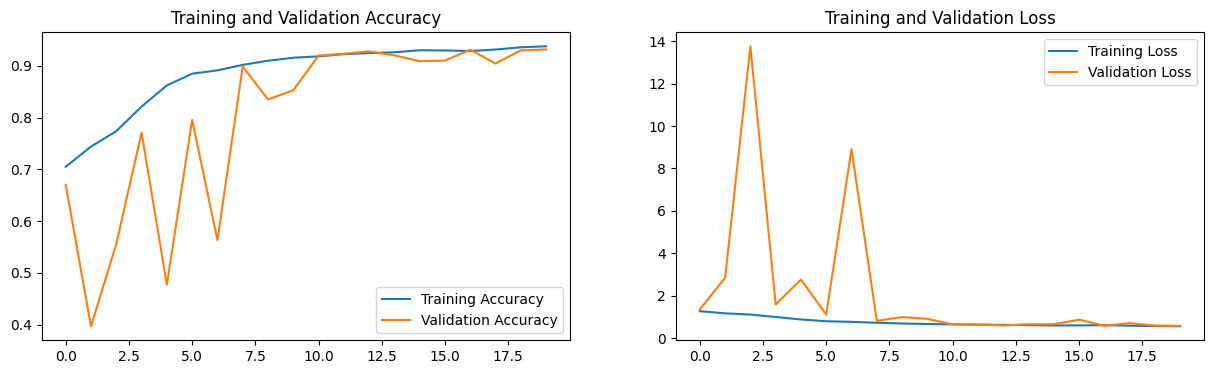

In [78]:
import matplotlib.pyplot as plt
EPOCHS = 20
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict on validation data
val_predictions = model.predict(val_data1)

# Convert predictions to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)

# Convert true labels to class labels
val_true_labels = np.argmax(val_labels1, axis=1)

# Calculate accuracy
accuracy = accuracy_score(val_true_labels, val_pred_labels)

# Calculate precision
precision = precision_score(val_true_labels, val_pred_labels, average='weighted')

# Calculate recall
recall = recall_score(val_true_labels, val_pred_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

# Calculate AUC-ROC score
roc_auc = roc_auc_score(val_labels1, val_predictions, average='macro', multi_class='ovo')

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)


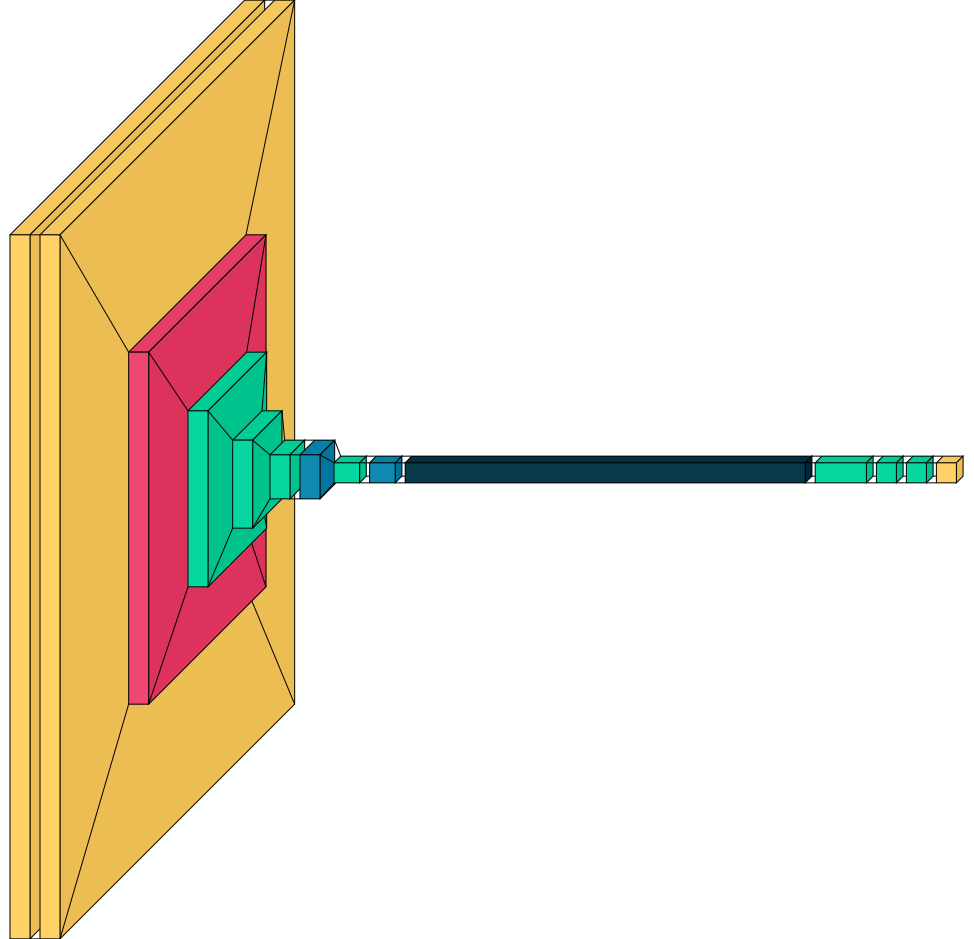

In [79]:
import visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# Constants
IMG_SIZE = 176  # As defined earlier
test_dir = "AlzheimerDataset/test/"  # Specify the correct path to your test dataset


In [3]:

# Load the model
model = load_model("alzheimer_model.h5")


In [4]:

# A function to preprocess the images
def preprocess_image(image_path, img_size=IMG_SIZE):
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Model expects a batch of images as input
    img /= 255.0  # Rescale
    return img


In [5]:

# Define Alzheimer's stages for prediction output
stages = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']


1/1 [==============================] - 0s 62ms/step


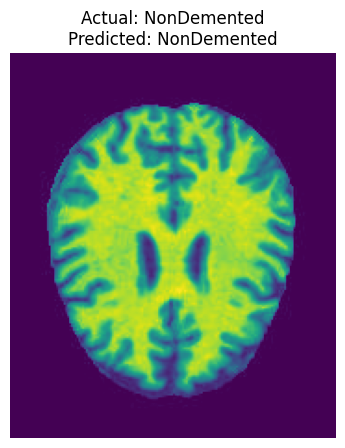

1/1 [==============================] - 0s 34ms/step


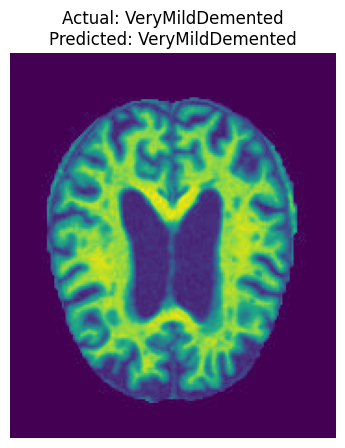

1/1 [==============================] - 0s 50ms/step


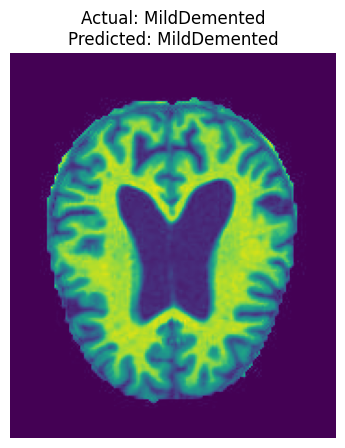

1/1 [==============================] - 0s 48ms/step


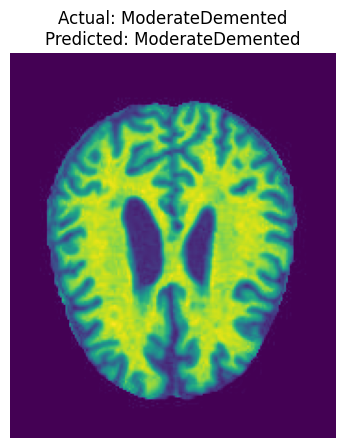

In [12]:
# Loop through each class directory
for stage in stages:
    stage_dir = os.path.join(test_dir, stage)
    
    # Get all images in this directory
    test_images = [os.path.join(stage_dir, f) for f in os.listdir(stage_dir) if os.path.isfile(os.path.join(stage_dir, f))]
    
    # Randomly select one image from this directory (or more if you prefer)
    random_image_path = random.choice(test_images)
    
    img = preprocess_image(random_image_path)
    prediction = model.predict(img)
    predicted_class = stages[np.argmax(prediction)]
    
    # Display the image, actual, and predicted class
    plt.figure(figsize=(5,5))
    plt.imshow(plt.imread(random_image_path))
    plt.title(f'Actual: {stage}\nPredicted: {predicted_class}')
    plt.axis('off')  # Optional; hides the axis for a cleaner look
    plt.show()

NameError: name 'val_data1' is not defined